Initialize the environment

In [22]:
from TamGen_Demo import TamGenDemo, prepare_pdb_data, prepare_pdb_data_center
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True,
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

Set the PDB you want to generate cmpds

In [2]:
pdb_id = "7te0" # "5dzk, 7d1m" "7te0"
prepare_pdb_data(pdb_id,)


[RUN] c:\Users\chusa\miniconda3\envs\TamGen2\python.exe scripts/build_data/prepare_pdb_ids.py tmp_pdb.csv gen_7te0 -o TamGen_Demo_Data -t 10
Processing 7te0
Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation', source_lang='tg', target_lang='m1', trainpref=None, validpref=None, testpref='TamGen_Demo_Data\\src/gen_7te0', destdir='TamGen_Demo_Data\\tmp', thresholdtgt=0, thresholdsrc=0, tgtdict='d:\\MASTER\\TamGen_play\\dict\\dict.m1.txt', srcdict='d:\\MASTER\\TamGen_play\\dict\\dict.tg.txt', nwordstgt=-1, nwordssrc=-1, alignfile=None, dataset_impl='mmap', joined_dictionary=False, only_source=False, padding_factor=8, workers=4)
|

FileNotFoundError: Expected output at TamGen_Demo_Data\gen_7te0, but it was not created.

In [24]:
prepare_pdb_data("7TE0", DemoDataFolder="TamGen_Demo_Data", thr=10)  # -> gen_7te0_t10
prepare_pdb_data("7TE0", DemoDataFolder="TamGen_Demo_Data", thr=15)  # -> gen_7te0_t15

# explicit center (example coords; replace with yours)
prepare_pdb_data_center("7TE0", center_xyz=(12.3, 34.5, 6.7),
                        DemoDataFolder="TamGen_Demo_Data", thr=12)

[RUN] c:\Users\chusa\miniconda3\envs\TamGen2\python.exe scripts/build_data/prepare_pdb_ids.py tmp_pdb.csv gen_7te0 -o TamGen_Demo_Data -t 10
Processing 7TE0
Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation', source_lang='tg', target_lang='m1', trainpref=None, validpref=None, testpref='TamGen_Demo_Data\\src/gen_7te0', destdir='TamGen_Demo_Data\\tmp', thresholdtgt=0, thresholdsrc=0, tgtdict='d:\\MASTER\\TamGen_play\\dict\\dict.m1.txt', srcdict='d:\\MASTER\\TamGen_play\\dict\\dict.tg.txt', nwordstgt=-1, nwordssrc=-1, alignfile=None, dataset_impl='mmap', joined_dictionary=False, only_source=False, padding_factor=8, workers=4)
|

RuntimeError: prepare_pdb_ids.py failed (rc=1). See error above.

Visualize the molecules

In [3]:
worker.reload_data(subset="gen_" + pdb_id.lower())

hyps, ref = worker.sample(
    m_sample=5000, 
    maxseed=30,
)

| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.m1
| ./TamGen_Demo_Data gen_7te0 tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.tg.coord


 97%|█████████▋| 29/30 [02:30<00:05,  5.17s/it]


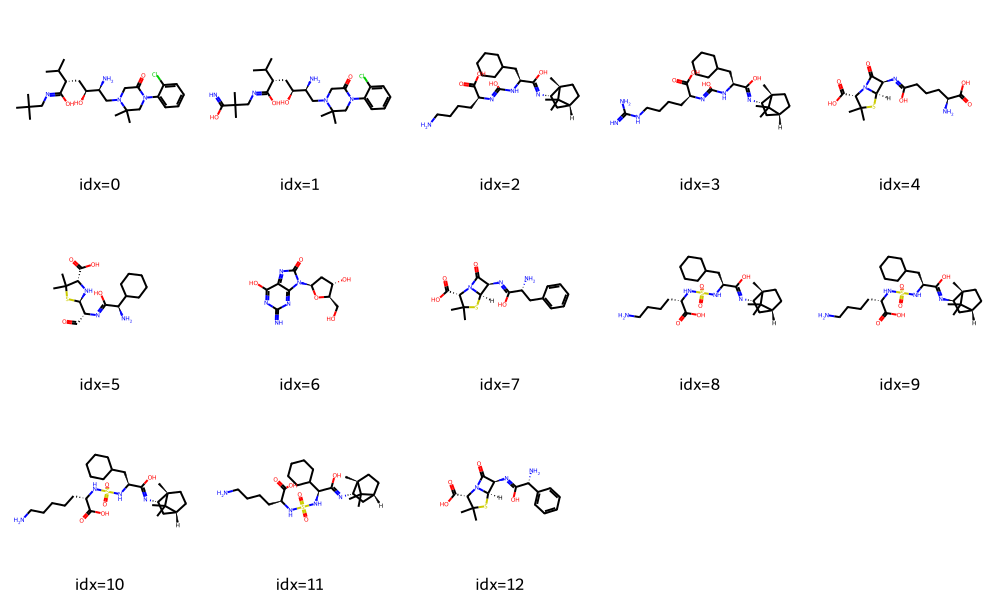

In [4]:
from rdkit import Chem 
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem import MACCSkeys

fp_ref = MACCSkeys.GenMACCSKeys(ref)

gens = []

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens.append((v,k, similarity))

sorted_gen = sorted(gens, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}".format(ii) for ii in range(len(sorted_gen))])
img

In [6]:
gens

[(<rdkit.Chem.rdchem.Mol at 0x18882710eb0>,
  'CC(C)[C@H](C[C@H](O)[C@@H](N)CN1CC(=O)N(c2ccccc2Cl)CC1(C)C)C(O)=NCC(C)(C)C(=N)O',
  0.6582278481012658),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a510>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O',
  0.5657894736842105),
 (<rdkit.Chem.rdchem.Mol at 0x18882710b30>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NS(=O)(=O)N[C@@H](CCCCN)C(=O)O)C2',
  0.5595238095238095),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a7b0>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)CCC[C@H](N)C(=O)O)C(=O)N2[C@H]1C(=O)O',
  0.5921052631578947),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a200>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O',
  0.5333333333333333),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a660>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NC(O)=N[C@@H](CCCCN)C(=O)O)C2',
  0.647887323943662),
 (<rdkit.Chem.rdchem.Mol at 0x188824775f0>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NC(O)=N[C@@H](CCCCNC(=N)N)C(

In [7]:
worker.reload_data(subset="gen_" + pdb_id.lower())

hyps, ref = worker.sample(
    m_sample=1000, 
    maxseed=30,
)

| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.m1
| ./TamGen_Demo_Data gen_7te0 tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.tg.coord


  0%|          | 0/30 [00:03<?, ?it/s]


KeyboardInterrupt: 

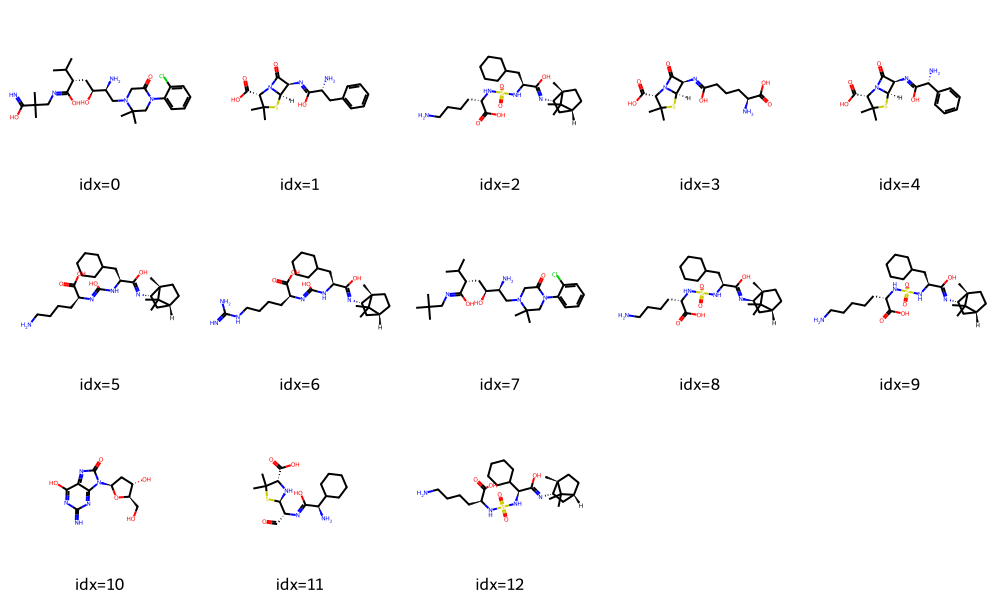

In [8]:
gens_2 = []

fp_ref = MACCSkeys.GenMACCSKeys(ref)

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens_2.append((v,k, similarity))

sorted_gen = sorted(gens_2, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in gens_2], molsPerRow=5, legends=["idx={}".format(ii) for ii in range(len(gens_2))])
img

In [9]:
gens_2

[(<rdkit.Chem.rdchem.Mol at 0x188705363c0>,
  'CC(C)[C@H](C[C@H](O)[C@@H](N)CN1CC(=O)N(c2ccccc2Cl)CC1(C)C)C(O)=NCC(C)(C)C(=N)O',
  0.6582278481012658),
 (<rdkit.Chem.rdchem.Mol at 0x18870536cf0>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O',
  0.5657894736842105),
 (<rdkit.Chem.rdchem.Mol at 0x188705366d0>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NS(=O)(=O)N[C@@H](CCCCN)C(=O)O)C2',
  0.5595238095238095),
 (<rdkit.Chem.rdchem.Mol at 0x18870536e40>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)CCC[C@H](N)C(=O)O)C(=O)N2[C@H]1C(=O)O',
  0.5921052631578947),
 (<rdkit.Chem.rdchem.Mol at 0x18870536f20>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O',
  0.5333333333333333),
 (<rdkit.Chem.rdchem.Mol at 0x18870536200>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NC(O)=N[C@@H](CCCCN)C(=O)O)C2',
  0.647887323943662),
 (<rdkit.Chem.rdchem.Mol at 0x18870536740>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NC(O)=N[C@@H](CCCCNC(=N)N)C(

In [34]:
worker_nocondition = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=False,
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

In [41]:
worker_nocondition.reload_data(subset="gen_" + pdb_id.lower())


| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.tg
| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.m1
| ./TamGen_Demo_Data gen_7te0 tg-m1 1 examples
| loaded 1 examples from: ./TamGen_Demo_Data\gen_7te0.tg-m1.tg.coord


In [42]:
hyps, ref = worker_nocondition.sample(
    m_sample=2000, 
    maxseed=20,
)

 95%|█████████▌| 19/20 [01:31<00:04,  4.84s/it]


c:\Users\chusa\miniconda3\envs\TamGen2\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


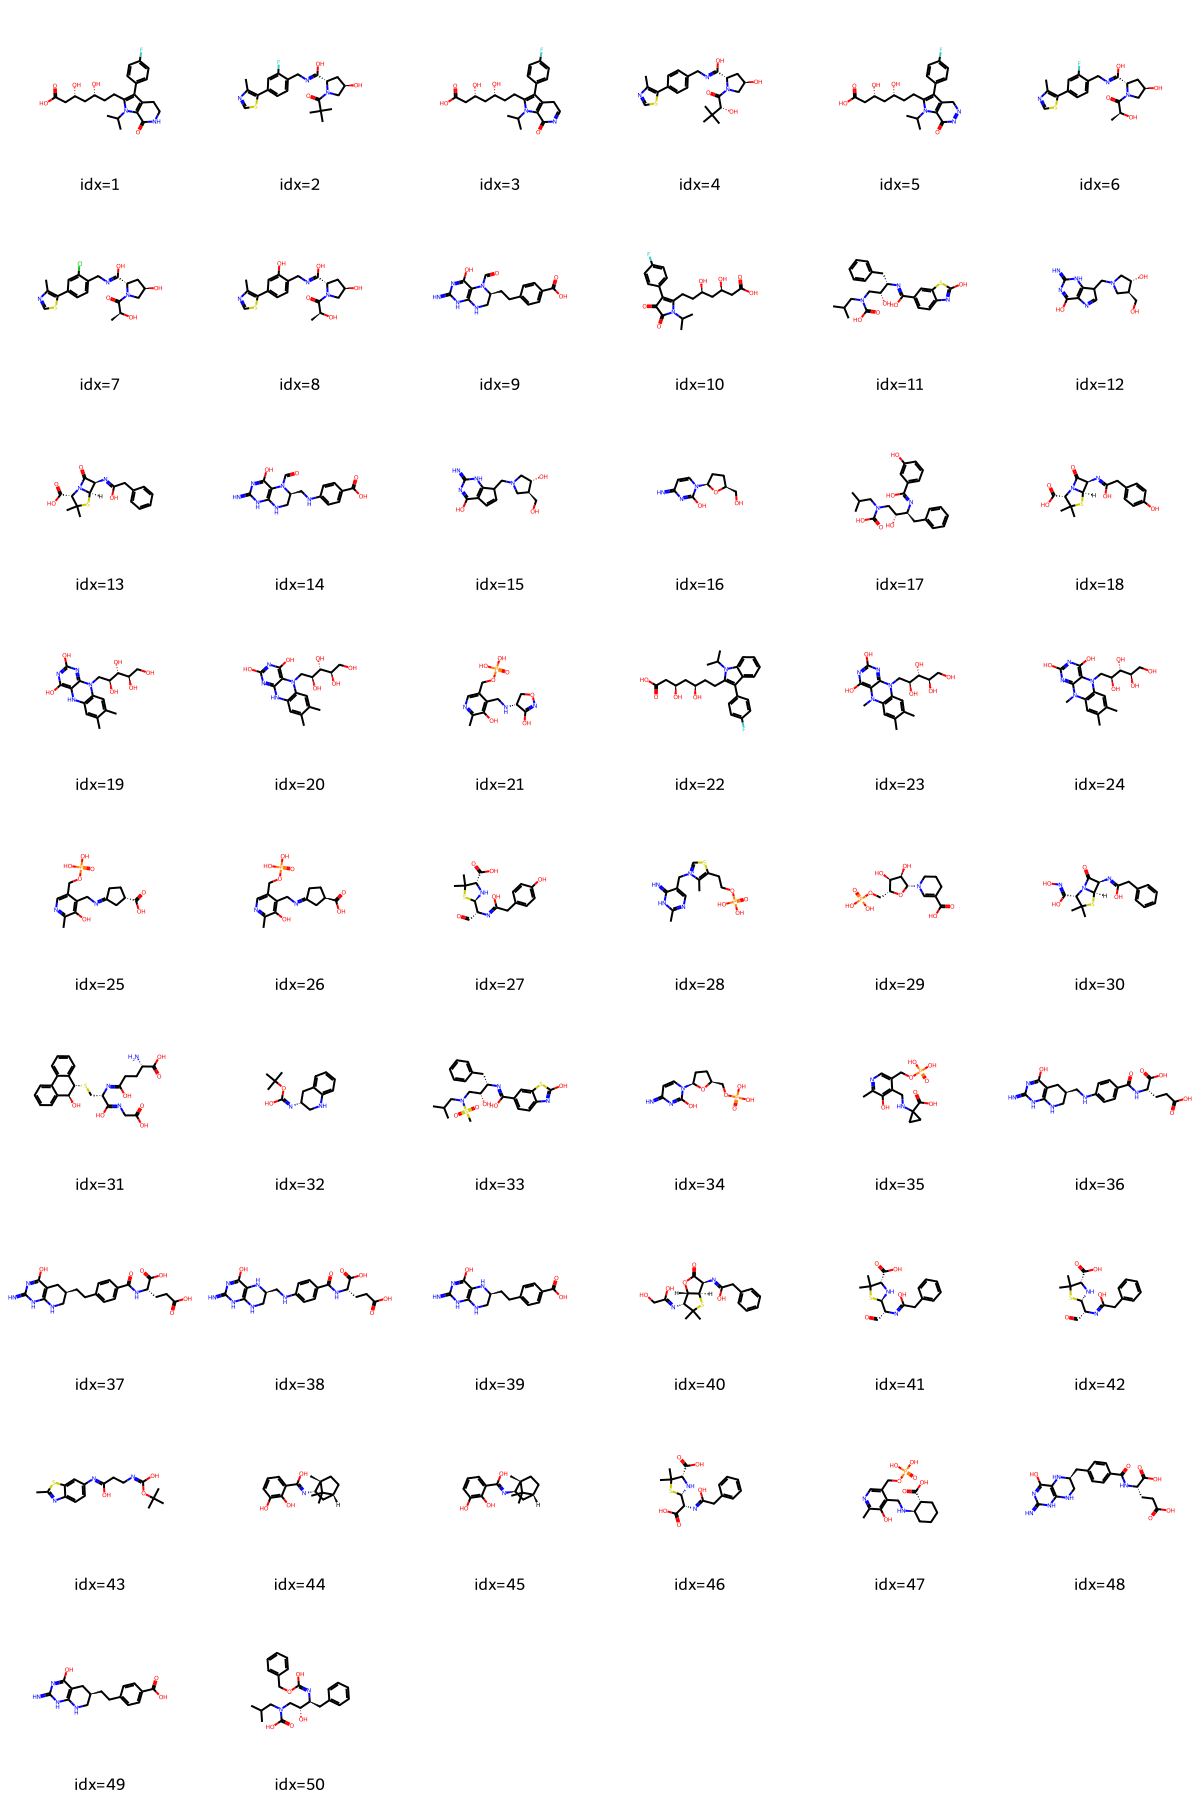

In [43]:
gens_3 = []
fp_ref = MACCSkeys.GenMACCSKeys(ref)

for k,v in hyps.items():
    fp = MACCSkeys.GenMACCSKeys(v)
    similarity = DataStructs.FingerprintSimilarity(fp_ref, fp, metric=DataStructs.TanimotoSimilarity)
    gens_3.append((v,k, similarity))

sorted_gen = sorted(gens_3, key=lambda e: e[-1], reverse=True)

# img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=5, legends=["idx={}, morgan={:.2f}".format(ii, e[2]) for ii, e in enumerate(sorted_gen)])
img=Draw.MolsToGridImage([e[0] for e in sorted_gen], molsPerRow=6, legends=["idx={}".format(ii+1) for ii in range(len(sorted_gen))])

img

In [4]:
import torch
import torch_cluster

In [28]:
import pandas as pd
import numpy as np
df = pd.read_csv("tmp_pdb.csv")  # or "utf-8-sig" if BOMmed UTF-8
df.to_csv("tmp_pdb.csv", index=False, encoding="utf-8")

In [6]:
print("torch", torch.__version__, "cuda", torch.version.cuda)
print("torch_cluster:", torch_cluster.__file__)

# diversity: compute Morgan FPs then 1 - average Tanimoto across the set


torch 2.3.0 cuda 12.1
torch_cluster: c:\Users\chusa\miniconda3\envs\TamGen2\lib\site-packages\torch_cluster\__init__.py


## RDKIT EVALUATION

In [12]:
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, rdMolDescriptors, DataStructs
# SAScore: put sascorer.py on PYTHONPATH (from RDKit contrib)
import sys
from rdkit.Chem import RDConfig

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

import sascorer


In [19]:
gens

[(<rdkit.Chem.rdchem.Mol at 0x18882710eb0>,
  'CC(C)[C@H](C[C@H](O)[C@@H](N)CN1CC(=O)N(c2ccccc2Cl)CC1(C)C)C(O)=NCC(C)(C)C(=N)O',
  0.6582278481012658),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a510>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O',
  0.5657894736842105),
 (<rdkit.Chem.rdchem.Mol at 0x18882710b30>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NS(=O)(=O)N[C@@H](CCCCN)C(=O)O)C2',
  0.5595238095238095),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a7b0>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)CCC[C@H](N)C(=O)O)C(=O)N2[C@H]1C(=O)O',
  0.5921052631578947),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a200>,
  'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O',
  0.5333333333333333),
 (<rdkit.Chem.rdchem.Mol at 0x18882b9a660>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NC(O)=N[C@@H](CCCCN)C(=O)O)C2',
  0.647887323943662),
 (<rdkit.Chem.rdchem.Mol at 0x188824775f0>,
  'CC1(C)[C@@H]2CC[C@@]1(C)[C@@H](N=C(O)[C@H](CC1CCCCC1)NC(O)=N[C@@H](CCCCNC(=N)N)C(

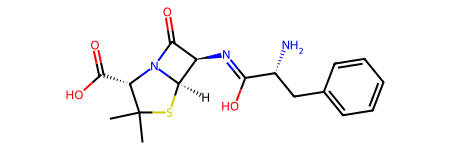

In [39]:
m = Chem.MolFromSmiles(gens[1][1])
m


#### Cannonical smiles

In [37]:
Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)

'CC1(C)S[C@@H]2[C@H](N=C(O)[C@H](N)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O'

In [43]:
try:
    import sascorer  # RDKit contrib (Ertl & Schuffenhauer)
    HAS_SA = True
except Exception:
    HAS_SA = False

def canon(smi: str):
    m = Chem.MolFromSmiles(smi)
    if not m:
        return None, None
    return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True), m

def lipinski_violations(m):
    mw   = Descriptors.MolWt(m)
    hbd  = rdMolDescriptors.CalcNumHBD(m)
    hba  = rdMolDescriptors.CalcNumHBA(m)
    logp = Descriptors.MolLogP(m)
    viol = int(mw>500) + int(hbd>5) + int(hba>10) + int(logp>5)
    return viol

def per_mol_metrics(m):
    row = {}
    row['qed']  = QED.qed(m)
    row['mw']   = Descriptors.MolWt(m)
    row['logp'] = Descriptors.MolLogP(m)
    row['hbd']  = rdMolDescriptors.CalcNumHBD(m)
    row['hba']  = rdMolDescriptors.CalcNumHBA(m)
    row['sa']   = (sascorer.calculateScore(m) if HAS_SA else None)
    row['lipinski_viol'] = lipinski_violations(m)
    row['lipinski_pass'] = int(row['lipinski_viol'] == 0)
    return row

def morgan_fp(m, radius=2, nbits=2048): # molecule to morgan fingerprint
    return rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)

def evaluate_smiles(smiles_list, sample_pairs_cap=50000):
    # Canonicalize, drop invalid, collect metrics
    can, mols, fps, rows = [], [], [], []
    for smi in smiles_list:
        cs, m = canon(smi)
        if cs is None:
            continue
        can.append(cs); mols.append(m); fps.append(morgan_fp(m))
        r = per_mol_metrics(m)
        r['smiles'] = cs
        rows.append(r)
        
    n_total    = len(smiles_list)
    n_valid    = len(mols)
    uniq_count = len(set(can))
    validity   = 100.0 * n_valid / max(1, n_total)
    uniqueness = 100.0 * uniq_count / max(1, n_valid)

    # Diversity: 1 - mean Tanimoto over (sampled) distinct pairs
    diversity = None
    if len(fps) >= 2:
        # sample up to 'sample_pairs_cap' random pairs for speed
        idx = np.arange(len(fps))
        pairs = []
        # exact pairs if small; otherwise sample
        if (len(fps)*(len(fps)-1))//2 <= sample_pairs_cap:
            for i in range(len(fps)):
                for j in range(i+1, len(fps)):
                    pairs.append((i,j))
        else:
            rng = np.random.default_rng(0)
            for _ in range(sample_pairs_cap):
                i, j = rng.integers(0, len(fps), 2)
                if i==j: 
                    j = (j+1) % len(fps)
                if i>j: i,j = j,i
                pairs.append((i,j))
            # de-dup sampled pairs
            pairs = list(set(pairs))

            
        sims = [DataStructs.TanimotoSimilarity(fps[i], fps[j]) for i,j in pairs]
        diversity = float(1.0 - (sum(sims)/len(sims)))

    df = pd.DataFrame(rows)
    summary = {
        'n_total': n_total,
        'n_valid': n_valid,
        'molecule_validity_%': round(validity, 2),
        'n_unique': uniq_count,
        'uniqueness_%': round(uniqueness, 2),
        'qed_mean': round(float(df['qed'].mean()) if not df.empty else float('nan'), 3),
        'sa_mean':  round(float(df['sa'].mean())  if HAS_SA and not df.empty else float('nan'), 3),
        'logp_mean': round(float(df['logp'].mean()) if not df.empty else float('nan'), 3),
        'lipinski_pass_%': round(100.0*float(df['lipinski_pass'].mean()) if not df.empty else 0.0, 2),
        'diversity_(1-meanTanimoto)': (round(diversity, 3) if diversity is not None else None),
    }
    return df, summary

In [42]:
smiles = [row[1] for row in gens]   # adjust if your structure differs
df, summary = evaluate_smiles(smiles)

# Save results and print summary
df.to_csv("results/metrics_7te0.csv", index=False)
print(summary)

{'n_total': 13, 'n_valid': 13, 'validity_%': 100.0, 'n_unique': 13, 'uniqueness_%': 100.0, 'qed_mean': 0.259, 'sa_mean': 4.768, 'logp_mean': 2.51, 'lipinski_pass_%': 53.85, 'diversity_(1-meanTanimoto)': 0.713}


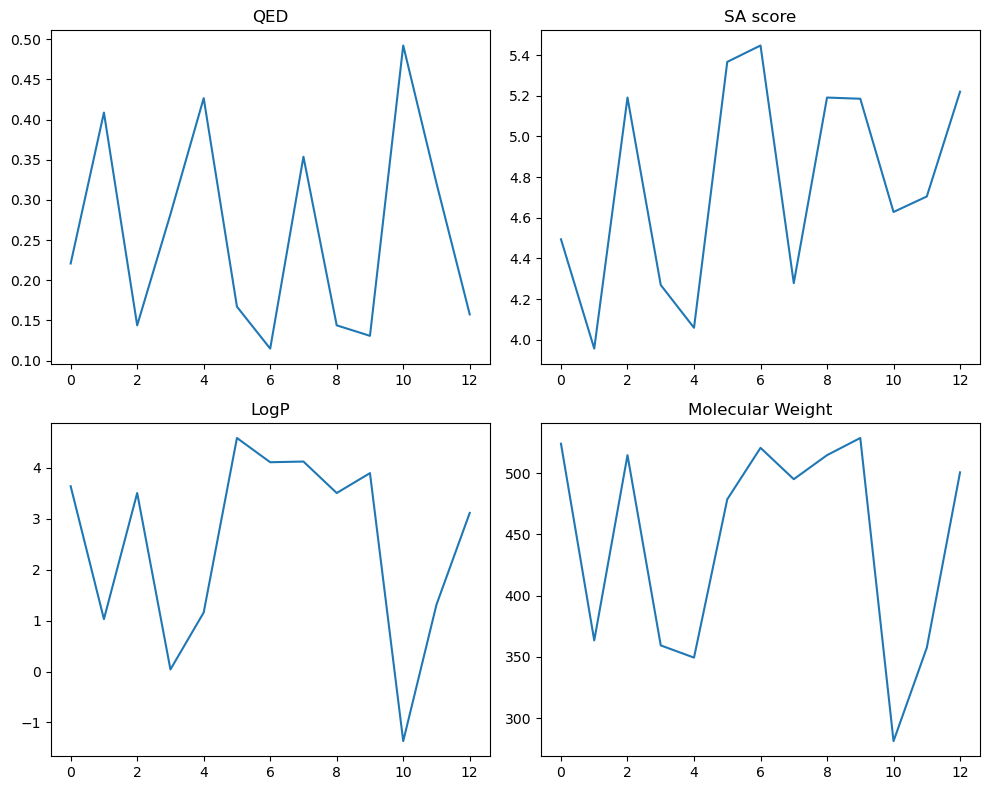

In [49]:
import matplotlib.pyplot as plt

def plot(ax, data, title, bins=30):
    ax.plot(data)
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(10,8))
if not df.empty:
    plot(axs[0,0], df['qed'],           'QED')
    plot(axs[0,1], df['sa'].dropna(),   'SA score')
    plot(axs[1,0], df['logp'],          'LogP')
    plot(axs[1,1], df['mw'],            'Molecular Weight')
plt.tight_layout()
plt.show()


In [50]:
df.describe()

,qed,mw,logp,hbd,hba,sa,lipinski_viol,lipinski_pass
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.258716,445.269385,2.510093,4.461538,5.076923,4.768487,0.538462,0.538462
std,0.129735,88.070586,1.860254,1.126601,0.640513,0.524708,0.660225,0.518875
min,0.114971,281.228000,-1.365430,3.000000,4.000000,3.956388,0.000000,0.000000
25%,0.143934,359.404000,1.158400,4.000000,5.000000,4.278566,0.000000,0.000000
50%,0.220879,495.108000,3.502900,5.000000,5.000000,4.704549,0.000000,1.000000
75%,0.353709,514.733000,3.893000,5.000000,5.000000,5.191020,1.000000,1.000000
max,0.492101,528.760000,4.582500,7.000000,6.000000,5.447053,2.000000,1.000000
